In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import os
from sentence_transformers import SentenceTransformer
warnings.filterwarnings('ignore')

plt.style.use('seaborn')

#wczytanie poziomów śmieszności
df = pd.read_excel('jester-data-1.xls', header=None, na_values=99)
df = df.fillna(df.mean())

model = SentenceTransformer('bert-base-cased')

pd.set_option('display.width', 2137)

jokes = []
for i in range(1, 101):
    with open(os.path.join('jokes', 'init{}.html'.format(i)), 'r') as f:
        joke = f.read()
        joke = joke.split('<!--begin of joke -->')[1]
        joke = joke.split('<!--end of joke -->')[0]
        joke = re.sub('<.*?>', '', joke)
        joke = re.sub('\n', ' ', joke)
        jokes.append(joke)

No sentence-transformers model found with name /Users/jakubradzik-vazco/.cache/torch/sentence_transformers/bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/jakubradzik-vazco/.cache/torch/sentence_transformers/bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertFor

In [17]:
df = df.drop(columns=[0])

In [18]:
# Ekstrakcja cech
joke_embeddings = model.encode(jokes)
df_jokes = pd.DataFrame(joke_embeddings)

# przypisanie średniej wartości oceny śmieszności do żartu
df_jokes['ratings'] = df.mean(axis=0).values

Tutaj robimy ekstrakcję cech z listy 100 żartów, a następnie przyporządowujemy im etykiety oznaczające średnią ocenę od użytkowników. Taki zbiór nadaje się już do podziału na zbiór uczący i walidacyjny.

1. Przygotuj zbiór uczący i walidacyjny, wykorzystując dołączony do listy kod procedury ekstrakcji cech.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_jokes.drop(columns=['ratings']), df_jokes['ratings'], test_size=0.1, random_state=2137)

2. Przetestuj działanie podstawowego modelu MLP o domyślnej konfiguracji hiperparametrów, ucząc go na danych ze zbioru Jester. Prześledź zachowanie modelu w czasie, wizualizując
wartość funkcji kosztu w funkcji liczby epok, zwracając uwagę na wartości dla zbioru uczącego
i zbioru walidacyjnego.

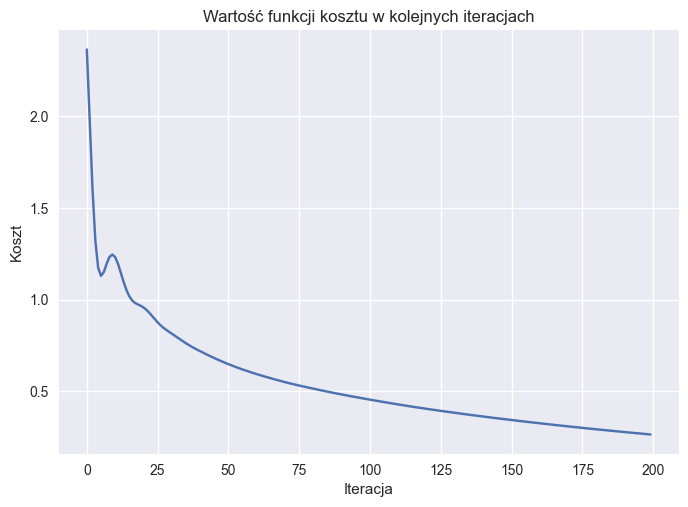

MSE:  1.221711292233851


In [20]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

mlp = MLPRegressor(
    random_state=2137,
    solver='sgd',
    alpha=0.0,
    learning_rate='constant',
)

mlp.fit(X_train, y_train)

plt.plot(mlp.loss_curve_)
plt.xlabel('Iteracja')
plt.ylabel('Koszt')
plt.title('Wartość funkcji kosztu w kolejnych iteracjach')
plt.show()

y_pred = mlp.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))


3. Zbadaj wpływ tempa uczenia (learning rate) na osiągane wyniki: powtórz uczenie dla 3 różnych wartości parametru. Dobierz odpowiednią długość procesu uczenia (liczbę epok) jeśli to
konieczne. Przedstaw wyniki na wykresach jak w zadaniu poprzednim. Co dzieje się, gdy tempo
uczenia jest zbyt niskie? Co, gdy zbyt wysokie?
4. Zbadaj wpływ rozmiaru modelu MLP na jakość działania: wykonaj co najmniej 3 eksperymenty
dla modeli różniących się liczbą neuronów. Kiedy model przestaje dobrze dopasowywać się do
danych? Kiedy zaczyna zanadto dopasowywać się do zbioru uczącego? (30 punktów)

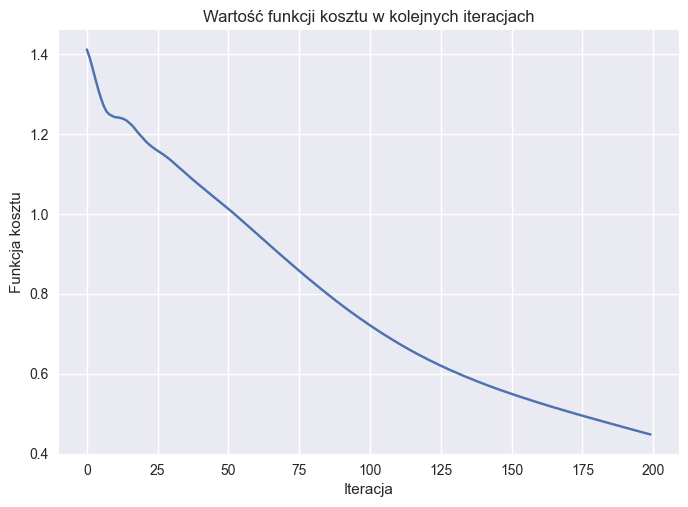

Learning rate:  constant
Hidden layer size:  (10,)
MSE:  0.9567627701744648


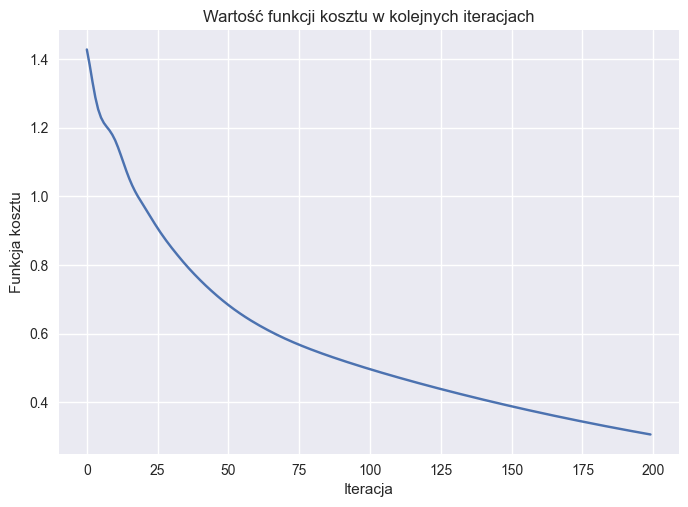

Learning rate:  constant
Hidden layer size:  (100,)
MSE:  1.0942199546834666


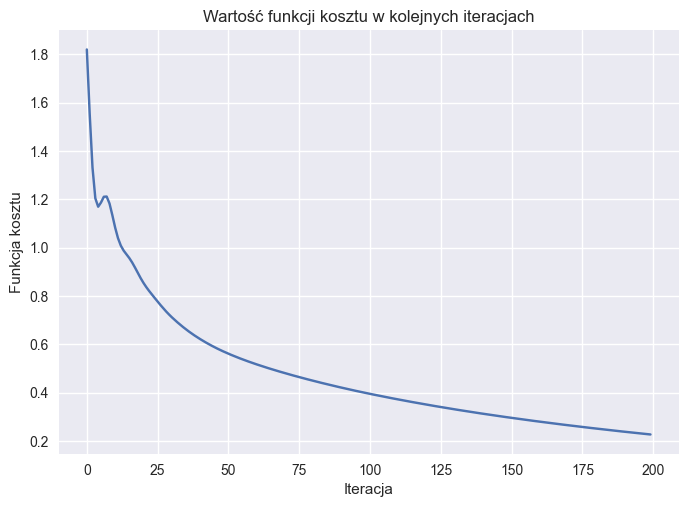

Learning rate:  constant
Hidden layer size:  (1000,)
MSE:  1.1384961893409709


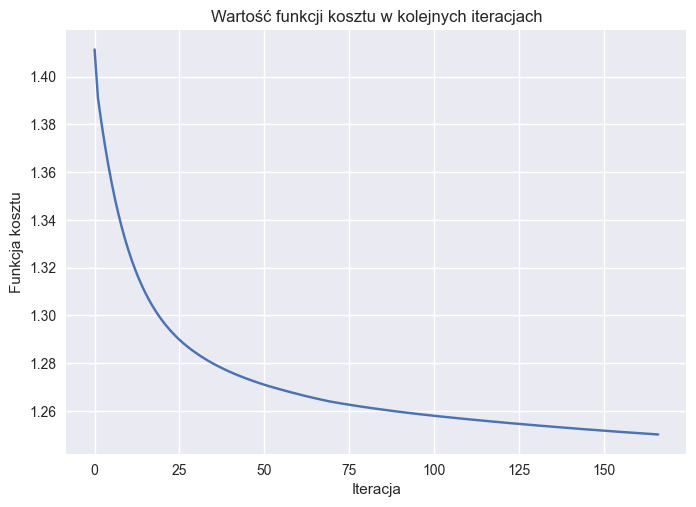

Learning rate:  invscaling
Hidden layer size:  (10,)
MSE:  1.2884899182890428


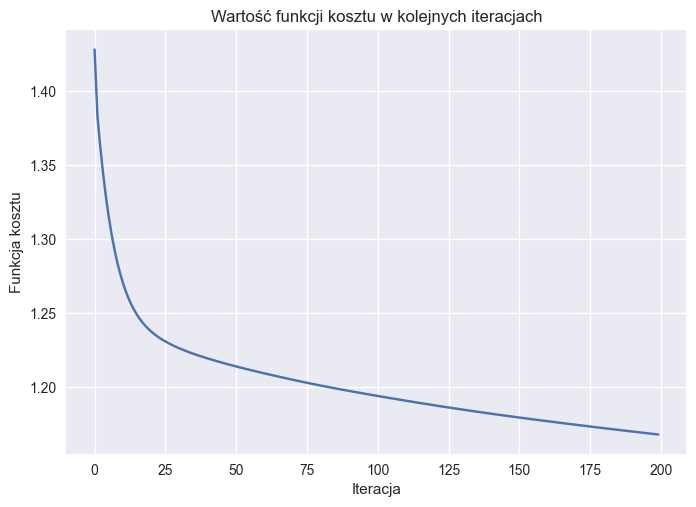

Learning rate:  invscaling
Hidden layer size:  (100,)
MSE:  1.1611486786000942


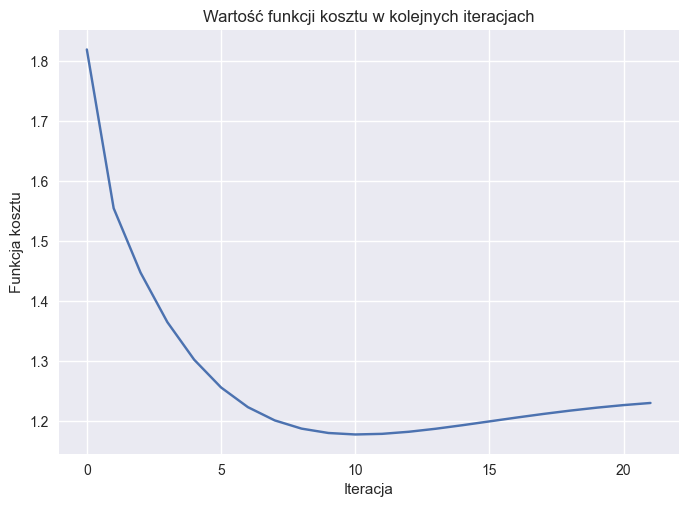

Learning rate:  invscaling
Hidden layer size:  (1000,)
MSE:  1.3476611781050991


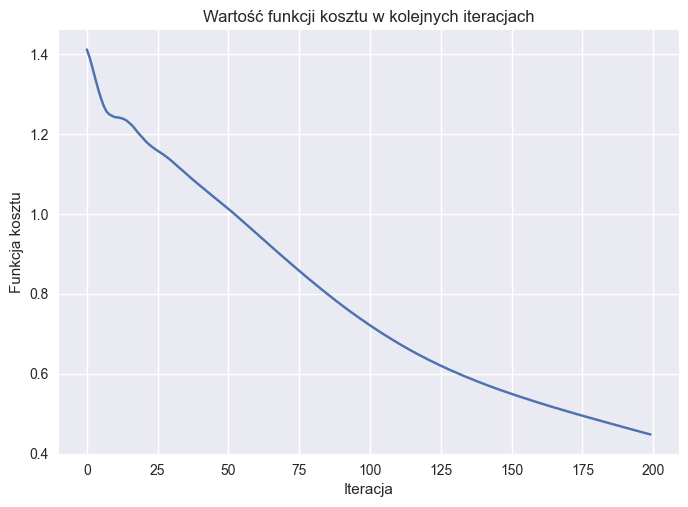

Learning rate:  adaptive
Hidden layer size:  (10,)
MSE:  0.9567627701744648


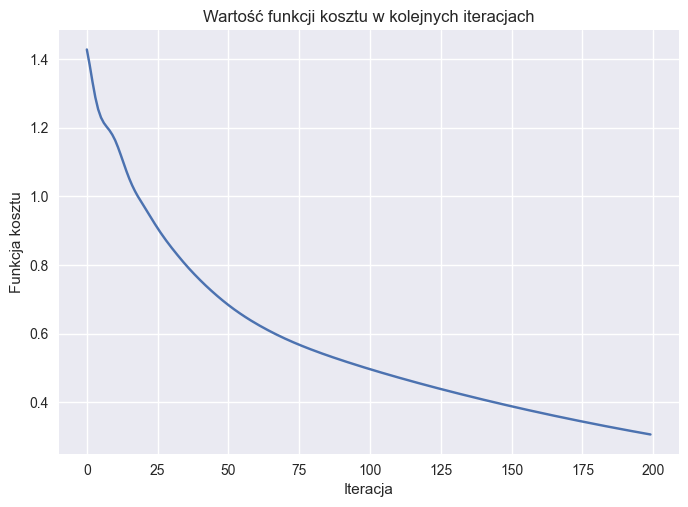

Learning rate:  adaptive
Hidden layer size:  (100,)
MSE:  1.0942199546834666


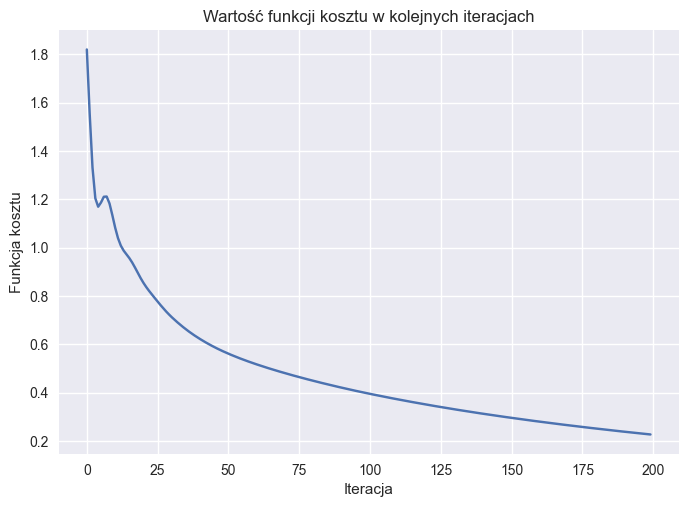

Learning rate:  adaptive
Hidden layer size:  (1000,)
MSE:  1.1384961893409709


In [21]:
learning_rates = ['constant', 'invscaling', 'adaptive']
hidden_layer_sizes = [(10,), (100,), (1000,)]
best_model = None
trained_models = []
for learning_rate in learning_rates:
    for hidden_layer_size in hidden_layer_sizes:
        mlp = MLPRegressor(
            random_state=42,
            solver='sgd',
            alpha=0.0,
            learning_rate=learning_rate,
            hidden_layer_sizes=hidden_layer_size
        )

        mlp.fit(X_train, y_train)

        import matplotlib.pyplot as plt
        plt.plot(mlp.loss_curve_)
        plt.xlabel('Iteracja')
        plt.ylabel('Funkcja kosztu')
        plt.title('Wartość funkcji kosztu w kolejnych iteracjach')
        plt.show()
        y_pred = mlp.predict(X_test)
        if best_model is None or mean_squared_error(y_test, y_pred) < best_model[0]:
            best_model = (mean_squared_error(y_test, y_pred), mlp, learning_rate, hidden_layer_size)
        print('Learning rate: ', learning_rate)
        print('Hidden layer size: ', hidden_layer_size)
        print('MSE: ', mean_squared_error(y_test, y_pred))
        trained_models.append((mean_squared_error(y_test, y_pred), mlp, learning_rate, hidden_layer_size))

Dla learning Rate - constant: mamy do czynienia z overfittingiem, gdyż wartość funkcji kosztu maleje w kolejnych iteracjach przy jedcznoczesnym zwiększaniu się błędu średniokwadratowego dla coraz większych ilości ukrtytych warstw

Dla invscaling zauważamy optymalny model przy 100 warstwach ukrytych po 7-8 iteracjach.

Adaptive w zasadzie tak samo jak Constant.

5.Wybierz najlepszy uzyskany w drodze powyższych eksperymentów model i przetestuj go w
praktyce: znajdź (lub napisz własny) tekst o charakterze dowcipu, przetwórz go na wektor za
pomocą używanej w zadaniach metody ekstrakcji cech, a następnie odpytaj model neuronowy.
Czy predykcja zgadza się z Twoim oczekiwaniem?

In [22]:
joke = "Do you know why John Paul 2 can't eat a hamburger? Because he is dead."
joke_embedding = model.encode([joke])
print('Predicted rating: ', best_model[1].predict(joke_embedding)[0])

Predicted rating:  -0.37039554


In [23]:
joke = "Why did Hitler die? Because he saw the gas bill."
joke_embedding = model.encode([joke])
print('Predicted rating: ', best_model[1].predict(joke_embedding)[0])

Predicted rating:  -1.3920248


To jest zła ocena śmieszności żartu

In [24]:
df_results = pd.DataFrame(trained_models, columns=['MSE', 'Model', 'Learning rate', 'Hidden layer size'])
df_results = df_results.sort_values(by=['MSE'])
df_results['Model'] = df_results['Model'].apply(lambda x: x.__class__.__name__)
print(df_results)

        MSE         Model Learning rate Hidden layer size
0  0.956763  MLPRegressor      constant             (10,)
6  0.956763  MLPRegressor      adaptive             (10,)
1  1.094220  MLPRegressor      constant            (100,)
7  1.094220  MLPRegressor      adaptive            (100,)
2  1.138496  MLPRegressor      constant           (1000,)
8  1.138496  MLPRegressor      adaptive           (1000,)
4  1.161149  MLPRegressor    invscaling            (100,)
3  1.288490  MLPRegressor    invscaling             (10,)
5  1.347661  MLPRegressor    invscaling           (1000,)
